In [3]:
import numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from celerite.modeling import Model, ConstantModel
import muhz2days

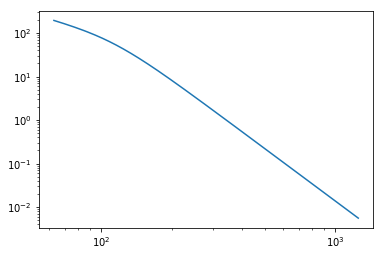

In [93]:
muhzconv = 1e6 / (3600*24)

def muhz2idays(muhz):
    return muhz / muhzconv

def muhz2omega(muhz):
    return muhz2idays(muhz) * 2.0 * np.pi

def idays2muhz(idays):
    return idays * muhzconv

def omega2muhz(omega):
    return idays2muhz(omega / (2.0 * np.pi))

omega = np.linspace(1, 300, 1000)
freqmuhz = omega2muhz(omega)
freqidays = muhz2idays(freqmuhz)
plt.loglog(omega, kernel.get_psd(omega));

In [362]:
data = np.loadtxt('/Users/samuelgrunblatt/Desktop/quicklook/211351816.dat.ts')
log_numax = np.log(200)
log_dnu = np.log(17.)

In [363]:
class ASTerm(terms.SHOTerm):
    parameter_names = ("log_numax", "log_dnu", "gamma_0", "gamma_1", "log_H0", "log_H1", "log_sigma", "log_Q")
    def get_all_coefficients(self, params=None):
        if params is None:
            params = self.get_parameter_vector(include_frozen=True)
        log_numax, log_dnu, gamma_0, gamma_1, log_H0, log_H1, log_sigma, log_Q = params
        gamma = np.array([gamma_0, gamma_1])
        H = np.exp([log_H0, log_H1])
        nunl, ampnl = self.modelfreq(np.exp(log_numax), np.exp(log_dnu), gamma, H, np.exp(log_sigma))
        coeffs = []
        for j in range(nunl.size):
            nu, amp = nunl.flat[j], ampnl.flat[j]
            log_S0 = np.log(amp)-2*log_Q
            log_omega = np.log(2*np.pi*nu)
            coeffs.append(super(ASTerm,self).get_all_coefficients([log_S0, log_Q, log_omega]))
        return [np.concatenate(args) for args in zip(*coeffs)]
        
    def modelfreq(self, numax, dnu, gammas, Hs, sigma):
        nprime = np.arange(-2,3,1)
        l = np.arange(len(gammas))
        nunl= numax + gammas[None,:] + (dnu * (nprime[:,None] + l[None,:]/2.))
        Anl = Hs[None,:]*np.exp(-(nunl - numax)**2/(2*sigma**2))
        return nunl, Anl

In [385]:
log_var = np.log(np.var(data[:, 1]))
k1 = ASTerm(
    log_numax=log_numax,
    log_dnu=log_dnu,
    gamma_0=0.0,
    gamma_1=0.0,
    log_H0=log_var,
    log_H1=log_var,
    log_sigma=np.log(10.0),
    log_Q=8.
)

k1.freeze_all_parameters()

k2 = terms.SHOTerm(log_Q=-0.5*np.log(2), log_S0=log_var, log_omega0=np.log(100))
k2.freeze_parameter("log_Q")

k3 = terms.SHOTerm(log_Q=-0.5*np.log(2), log_S0=log_var, log_omega0=np.log(150))
k3.freeze_parameter("log_Q")

k4 = terms.JitterTerm(0.5*log_var)

kernel = k1 + k2 + k3 + k4

In [386]:
kernel.coefficients

[array([], dtype=float64),
 array([], dtype=float64),
 array([  7.86188416e-11,   1.03618227e-09,   6.61509707e-09,
          2.04607032e-08,   3.06669548e-08,   2.22770580e-08,
          7.84413150e-09,   1.33902064e-09,   1.10824150e-10,
          4.44764752e-12,   5.14400814e-06,   7.71601221e-06]),
 array([  1.31868418e-14,   1.73800215e-13,   1.10955894e-12,
          3.43190067e-12,   5.14380870e-12,   3.73656026e-12,
          1.31570650e-12,   2.24595694e-13,   1.85886806e-14,
          7.46009772e-16,   5.14400814e-06,   7.71601221e-06]),
 array([   0.17494523,    0.18390327,    0.19286131,    0.20181935,
           0.21077739,    0.21973542,    0.22869346,    0.2376515 ,
           0.24660954,    0.25556758,   70.71067812,  106.06601718]),
 array([ 1043.00874632,  1096.41582068,  1149.82289504,  1203.2299694 ,
         1256.63704376,  1310.04411812,  1363.45119248,  1416.85826684,
         1470.2653412 ,  1523.67241556,    70.71067812,   106.06601718])]

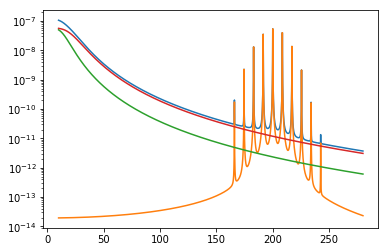

In [387]:
freq_muHz = np.linspace(10, 280, 10000)
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [388]:
time,flux = np.array(data[:,0])*0.0864, np.array(data[:,1])

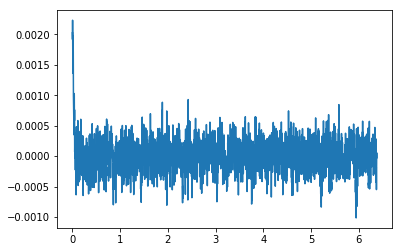

In [389]:
plt.plot(time,flux)

In [390]:
gp = celerite.GP(kernel)
gp.compute(time)

In [391]:
def nll(params):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(flux)

In [392]:
from scipy.optimize import minimize

soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
soln

      fun: -23423.238792842174
 hess_inv: array([[  3.52908391e-02,  -2.68740125e-02,   2.56967895e-02,
         -1.08887064e-02,  -1.20169298e-04],
       [ -2.68740125e-02,   2.13233433e-02,  -2.04667263e-02,
          8.74764119e-03,   9.47660643e-05],
       [  2.56967895e-02,  -2.04667263e-02,   2.16743073e-02,
         -8.63118896e-03,  -5.13764901e-04],
       [ -1.08887064e-02,   8.74764119e-03,  -8.63118896e-03,
          5.45767252e-03,  -3.09312840e-04],
       [ -1.20169298e-04,   9.47660643e-05,  -5.13764901e-04,
         -3.09312840e-04,   4.29172655e-04]])
      jac: array([-0.00366211, -0.00341797,  0.00732422,  0.00146484,  0.00097656])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 641
      nit: 28
     njev: 90
   status: 2
  success: False
        x: array([-21.12102347,   3.83853339, -23.1424231 ,   5.94807034,  -8.70504927])

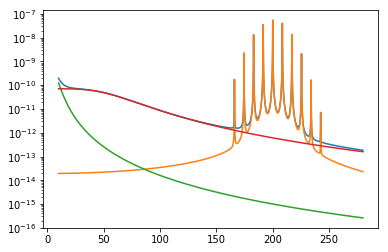

In [393]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

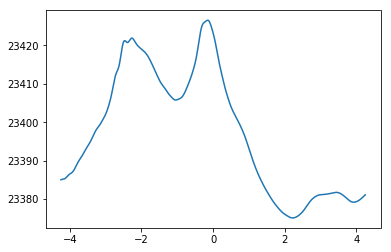

In [394]:
gammagrid = np.linspace(-0.25*np.exp(log_dnu),0.25*np.exp(log_dnu), 500)
like = np.empty_like(gammagrid)
for i,gamma in enumerate(gammagrid):
    k1.set_parameter("gamma_1", gamma)
    like[i] = gp.log_likelihood(flux)
best = gammagrid[np.argmax(like)]
k1.set_parameter("gamma_1", best)
plt.plot(gammagrid,like)

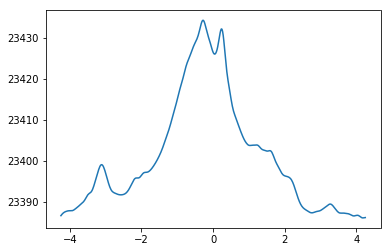

In [395]:
gammagrid = np.linspace(-0.25*np.exp(log_dnu),0.25*np.exp(log_dnu), 500)
like = np.empty_like(gammagrid)
for i,gamma in enumerate(gammagrid):
    k1.set_parameter("gamma_0", gamma)
    like[i] = gp.log_likelihood(flux)
best = gammagrid[np.argmax(like)]
k1.set_parameter("gamma_0", best)
plt.plot(gammagrid,like)

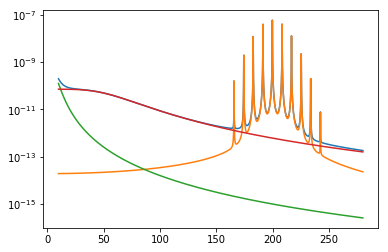

In [396]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [397]:
k1.thaw_parameter("gamma_0")
k1.thaw_parameter("gamma_1")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
soln

      fun: -23434.36624385942
 hess_inv: array([[  1.63379968e-03,  -1.01599729e-03,   2.02415310e-02,
         -1.05014540e-02,  -3.68924560e-04,   1.53398735e-04,
          1.53682342e-04],
       [ -1.01599729e-03,   6.68222707e-03,  -7.27175860e-02,
          3.59460841e-02,   5.06387004e-03,  -2.64648255e-03,
         -2.90601946e-04],
       [  2.02415310e-02,  -7.27175860e-02,   1.51968496e+00,
         -7.68811061e-01,  -8.28501970e-02,   3.48175463e-02,
          1.08195911e-02],
       [ -1.05014540e-02,   3.59460841e-02,  -7.68811061e-01,
          3.97652062e-01,   3.93893334e-02,  -1.74354635e-02,
         -5.17714277e-03],
       [ -3.68924560e-04,   5.06387004e-03,  -8.28501970e-02,
          3.93893334e-02,   6.13104977e-03,  -1.85498316e-03,
         -8.34063637e-04],
       [  1.53398735e-04,  -2.64648255e-03,   3.48175463e-02,
         -1.74354635e-02,  -1.85498316e-03,   2.37842204e-03,
         -3.87329229e-05],
       [  1.53682342e-04,  -2.90601946e-04,   1.08195

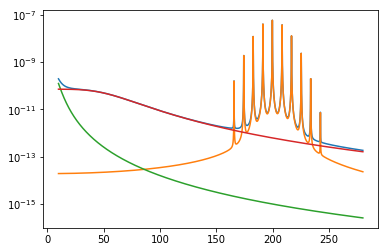

In [398]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [399]:
k1.thaw_parameter("log_H0")
k1.thaw_parameter("log_H1")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
soln

      fun: -23516.3775142709
 hess_inv: array([[  1.27132795e-03,   5.83110420e-05,   8.69906581e-04,
         -5.96329639e-04,  -6.84656034e-04,   9.34954330e-04,
         -1.01334313e-03,   9.39113536e-04,  -2.84649093e-04],
       [  5.83110420e-05,   6.12061612e-04,  -1.49797880e-04,
         -3.35869345e-04,  -5.16054402e-04,   7.58322627e-04,
         -1.38905174e-04,  -1.35313969e-05,   9.73348248e-06],
       [  8.69906581e-04,  -1.49797880e-04,   3.65191439e-03,
          7.46644127e-04,   1.01021585e-03,   2.60647413e-03,
         -4.25685188e-03,   2.00997513e-03,  -6.25352469e-04],
       [ -5.96329639e-04,  -3.35869345e-04,   7.46644127e-04,
          4.40489631e-03,   1.15217334e-03,  -3.44805084e-03,
         -2.31471494e-03,   7.02135849e-04,   7.91126759e-05],
       [ -6.84656034e-04,  -5.16054402e-04,   1.01021585e-03,
          1.15217334e-03,   3.15081050e-03,  -2.67088313e-04,
         -2.02187939e-03,  -7.13712421e-04,   4.61872009e-04],
       [  9.34954330e-04,

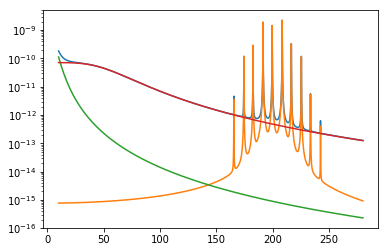

In [400]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

      fun: -23516.90357957961
 hess_inv: array([[  6.69655699e-04,  -2.47488860e-05,   3.35541940e-04,
         -3.50046738e-03,   3.08977574e-03,   7.67145688e-04,
         -7.12535886e-04,   4.09512539e-04,  -5.54085821e-04,
          1.36968112e-04],
       [ -2.47488860e-05,   5.23262397e-04,   1.66546513e-03,
         -4.75805376e-03,   2.78198819e-03,   1.13470132e-03,
         -8.46652312e-04,   7.83910685e-04,  -8.16508600e-04,
          1.54078734e-04],
       [  3.35541940e-04,   1.66546513e-03,   9.95599011e-02,
         -1.03911366e-01,   8.48840568e-02,  -1.55828631e-02,
         -7.49944106e-03,   7.57708472e-03,  -1.33078554e-02,
          3.46888823e-03],
       [ -3.50046738e-03,  -4.75805376e-03,  -1.03911366e-01,
          4.02906334e-01,  -3.70393720e-01,  -9.59153967e-02,
          8.90900904e-02,  -3.91973629e-02,   5.52131306e-02,
         -1.51803663e-02],
       [  3.08977574e-03,   2.78198819e-03,   8.48840568e-02,
         -3.70393720e-01,   3.91659533e-01,  

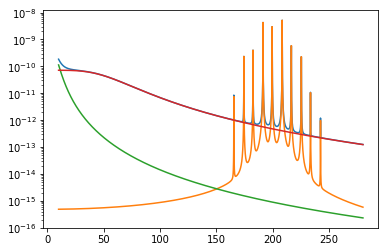

In [401]:
k1.thaw_parameter("log_Q")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
print(soln)

plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

      fun: -23531.259393406508
 hess_inv: array([[  2.01881030e-04,   8.30511354e-05,  -2.60322735e-04,
          1.40874967e-05,  -1.74559884e-04,   3.08502566e-04,
         -1.17231643e-04,   4.22700939e-05,   1.00226514e-04,
          5.08705744e-05,  -1.15438886e-04],
       [  8.30511354e-05,   2.21860848e-04,  -3.84763344e-04,
          1.12725147e-04,  -9.29797972e-05,   4.18180510e-04,
         -1.49290520e-04,   1.18861704e-04,   1.32584433e-04,
         -2.56103247e-05,  -2.11945790e-04],
       [ -2.60322735e-04,  -3.84763344e-04,   8.05489626e-04,
         -2.07206047e-04,   2.64780972e-04,  -8.81708252e-04,
          3.24383035e-04,  -2.31203567e-04,  -2.65618917e-04,
         -1.06678067e-06,   3.98477424e-04],
       [  1.40874967e-05,   1.12725147e-04,  -2.07206047e-04,
          8.55254622e-05,  -2.87459244e-05,   2.13489899e-04,
         -8.29412726e-05,   8.26987196e-05,   5.86980326e-05,
         -2.21471008e-05,  -1.09933704e-04],
       [ -1.74559884e-04,  -9.2979

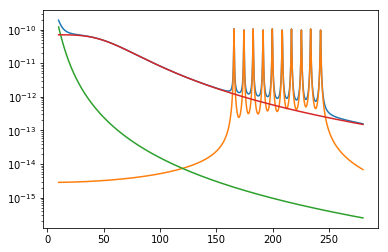

In [402]:
k1.thaw_parameter("log_sigma")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
print(soln)

plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

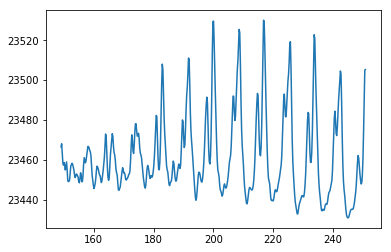

In [403]:
numaxgrid = np.linspace(-3*np.exp(log_dnu),3*np.exp(log_dnu), 500)+np.exp(log_numax)
like = np.empty_like(numaxgrid)
for i,numax in enumerate(numaxgrid):
    k1.set_parameter("log_numax", np.log(numax))
    like[i] = gp.log_likelihood(flux)
best = numaxgrid[np.argmax(like)]
k1.set_parameter("log_numax", np.log(best))
plt.plot(numaxgrid,like)

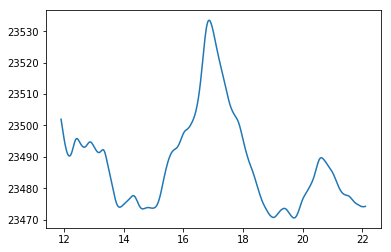

In [404]:
dnugrid = np.linspace(-0.3*np.exp(log_dnu),0.3*np.exp(log_dnu), 500)+np.exp(log_dnu)
like = np.empty_like(dnugrid)
for i,dnu in enumerate(dnugrid):
    k1.set_parameter("log_dnu", np.log(dnu))
    like[i] = gp.log_likelihood(flux)
best = dnugrid[np.argmax(like)]
k1.set_parameter("log_dnu", np.log(best))
plt.plot(dnugrid,like)

/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


      fun: -23552.909759241542
 hess_inv: array([[  1.21369511e-06,  -3.92489855e-08,  -2.61362441e-04,
         -2.61937340e-04,   1.69931706e-04,   2.89348115e-04,
         -1.19857597e-04,  -7.91345538e-05,  -1.51628430e-04,
          6.82483123e-05,   4.84337835e-05,  -1.73143042e-05,
         -1.75667030e-06],
       [ -3.92489858e-08,   3.41142144e-07,   4.09336993e-06,
          7.41396594e-06,   1.70671768e-05,  -2.17716470e-05,
          1.38834555e-06,   1.06899211e-06,   2.90797822e-06,
          1.25011039e-06,   2.76445494e-07,   8.47183110e-07,
         -6.90299567e-07],
       [ -2.61362441e-04,   4.09336990e-06,   5.66611477e-02,
          5.65966525e-02,  -3.69905396e-02,  -6.28228127e-02,
          2.67011636e-02,   1.71289349e-02,   3.24859790e-02,
         -1.43427929e-02,  -1.07863737e-02,   3.91258306e-03,
          3.79710905e-04],
       [ -2.61937340e-04,   7.41396586e-06,   5.65966525e-02,
          5.69389474e-02,  -3.72150742e-02,  -6.30635837e-02,
         

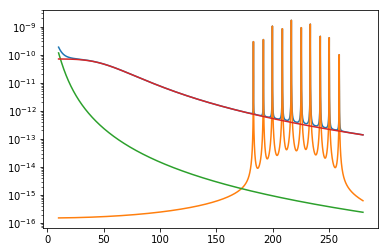

In [405]:
k1.thaw_all_parameters()
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
print(soln)

plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [357]:
from astropy.stats import LombScargle

model = LombScargle(time, flux)
power = model.power(freq_muHz)

(0.0003, 0.01)

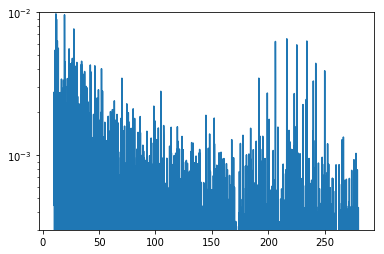

In [361]:
plt.semilogy(freq_muHz, power)
plt.ylim(3e-4,1e-2)

In [407]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_numax', 5.3864965832020788),
             ('kernel:terms[0]:log_dnu', 2.8226902552881423),
             ('kernel:terms[0]:gamma_0', -1.9525831382832401),
             ('kernel:terms[0]:gamma_1', -1.5128514912517284),
             ('kernel:terms[0]:log_H0', -19.79745793751502),
             ('kernel:terms[0]:log_H1', -19.962540719880316),
             ('kernel:terms[0]:log_sigma', 2.9352500677937585),
             ('kernel:terms[0]:log_Q', 9.0123375910599286),
             ('kernel:terms[1]:log_S0', -21.103286732791535),
             ('kernel:terms[1]:log_omega0', 3.8148782936163665),
             ('kernel:terms[2]:log_S0', -23.141957663834773),
             ('kernel:terms[2]:log_omega0', 5.9140992739564506),
             ('kernel:terms[3]:log_sigma', -8.6703019418300613)])

In [415]:
def lnprob(params, flux, gp):
    gp.set_parameter_vector(params)
    
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    
    ll = gp.log_likelihood(flux)
    if not np.isfinite(ll):
        return -np.inf
    return ll + lp 
        
# Set up the sampler.
import emcee
#import triangleedit
import time

merged_par = gp.get_parameter_vector()

from matplotlib.ticker import MaxNLocator
ndim, nwalkers = len(merged_par), 30
pos = [merged_par *(1+ 1e-3*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(flux,gp)) 
    
# Time an MCMC step, and estimate length of time to run chain.
t0 = time.time()
sampler.run_mcmc(pos, 1, rstate0=np.random.get_state())
tstep = time.time()-t0
Nsteps = 3000
from time import localtime, strftime
tstart = strftime("%a, %d %b %Y %H:%M:%S", localtime())
print("""MCMC step runtime (in seconds): {0}
        MCMC estimated total runtime (in seconds): {1}
        Start time: {2}
        """.format(tstep, tstep * Nsteps, tstart))

# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, Nsteps, rstate0=np.random.get_state())
print("Done.")
print("End time:", strftime("%a, %d %b %Y %H:%M:%S", localtime()))

burnin = 300

MCMC step runtime (in seconds): 0.3094751834869385
        MCMC estimated total runtime (in seconds): 928.4255504608154
        Start time: Mon, 26 Feb 2018 16:16:20
        
Running MCMC...
Done.
End time: Mon, 26 Feb 2018 16:24:02


In [416]:
[log_numax_mcmc, log_dnu_mcmc, gamma0_mcmc, gamma1_mcmc, log_H0_mcmc, \
    log_H1_mcmc, log_sigma_mcmc, log__Q0_mcmc, log_S00_mcmc, log_omega00_mcmc, log_S01_mcmc, log_omega01_mcmc, log_jit] = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, [16, 50, 84], axis=0))) 
print("""MCMC result:
numax = {0[0]} +{0[1]} -{0[2]} 
dnu = {1[0]} +{1[1]} -{1[2]}
gamma0 = {2[0]} +{2[1]} -{2[2]} 
gamma1 = {3[0]} +{3[1]} -{3[2]}
log_H0 = {4[0]} +{4[1]} -{4[2]} 
log_H1 = {5[0]} +{5[1]} -{5[2]}
log_sigma = {6[0]} +{6[1]} -{6[2]}
log_Q0 = {7[0]} +{7[1]} -{7[2]} 
log_S0,0 = {8[0]} +{8[1]} -{8[2]}
log_omega0,0 = {9[0]} +{9[1]} -{9[2]}
log_S0,1 = {10[0]} +{10[1]} -{10[2]}
log_omega0,1 = {11[0]} +{11[1]} -{11[2]}
log_whitenoise = {12[0]} +{12[1]} -{12[2]}
""".format(np.exp(log_numax_mcmc), np.exp(log_dnu_mcmc), gamma0_mcmc, gamma1_mcmc, log_H0_mcmc, \
    log_H1_mcmc, log_sigma_mcmc, log__Q0_mcmc, log_S00_mcmc, log_omega00_mcmc, log_S01_mcmc, log_omega01_mcmc, log_jit)) 
#lnper = {8[0]} +{8[1]} -{8[2]} 

print("Mean acceptance fraction: {0:.3f}"
        .format(np.mean(sampler.acceptance_fraction)))

MCMC result:
numax = 227.30961591102215 +1.035047528673113 -1.0404026570684366 
dnu = 16.26065735889764 +1.0353801434414205 -1.0268453720510873
gamma0 = -1.9756738548958843 +0.01648297233045648 -0.01771334431503213 
gamma1 = -1.5080302079758958 +0.01967467361736497 -0.021032983505209435
log_H0 = -20.18775372582208 +0.23829699757350298 -0.31400146120394723 
log_H1 = -19.969715391739474 +0.2570100268320381 -0.34722869127111977
log_sigma = 2.93743975308349 +0.04894866801580422 -0.04065066110006432
log_Q0 = 9.29435546664692 +0.2061408448100881 -0.11215572528987394 
log_S0,0 = -20.853559950504884 +0.22323414779464912 -0.4591069539735777
log_omega0,0 = 3.820734729556116 +0.044630581062047536 -0.0706104840141486
log_S0,1 = -23.25486614850171 +0.2337750814429853 -0.10627478492385833
log_omega0,1 = 5.890408848848865 +0.0670735167073131 -0.06342551946022379
log_whitenoise = -8.630964159436292 +0.019574335736555426 -0.03732953015073015

Mean acceptance fraction: 0.046


ERROR: IndexError: list index out of range [corner.corner]


IndexError: list index out of range

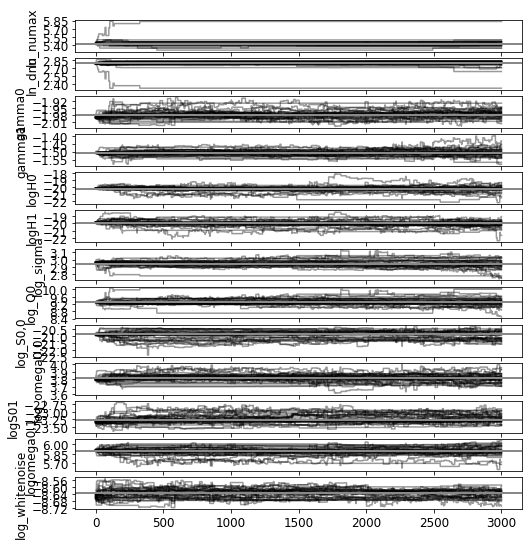

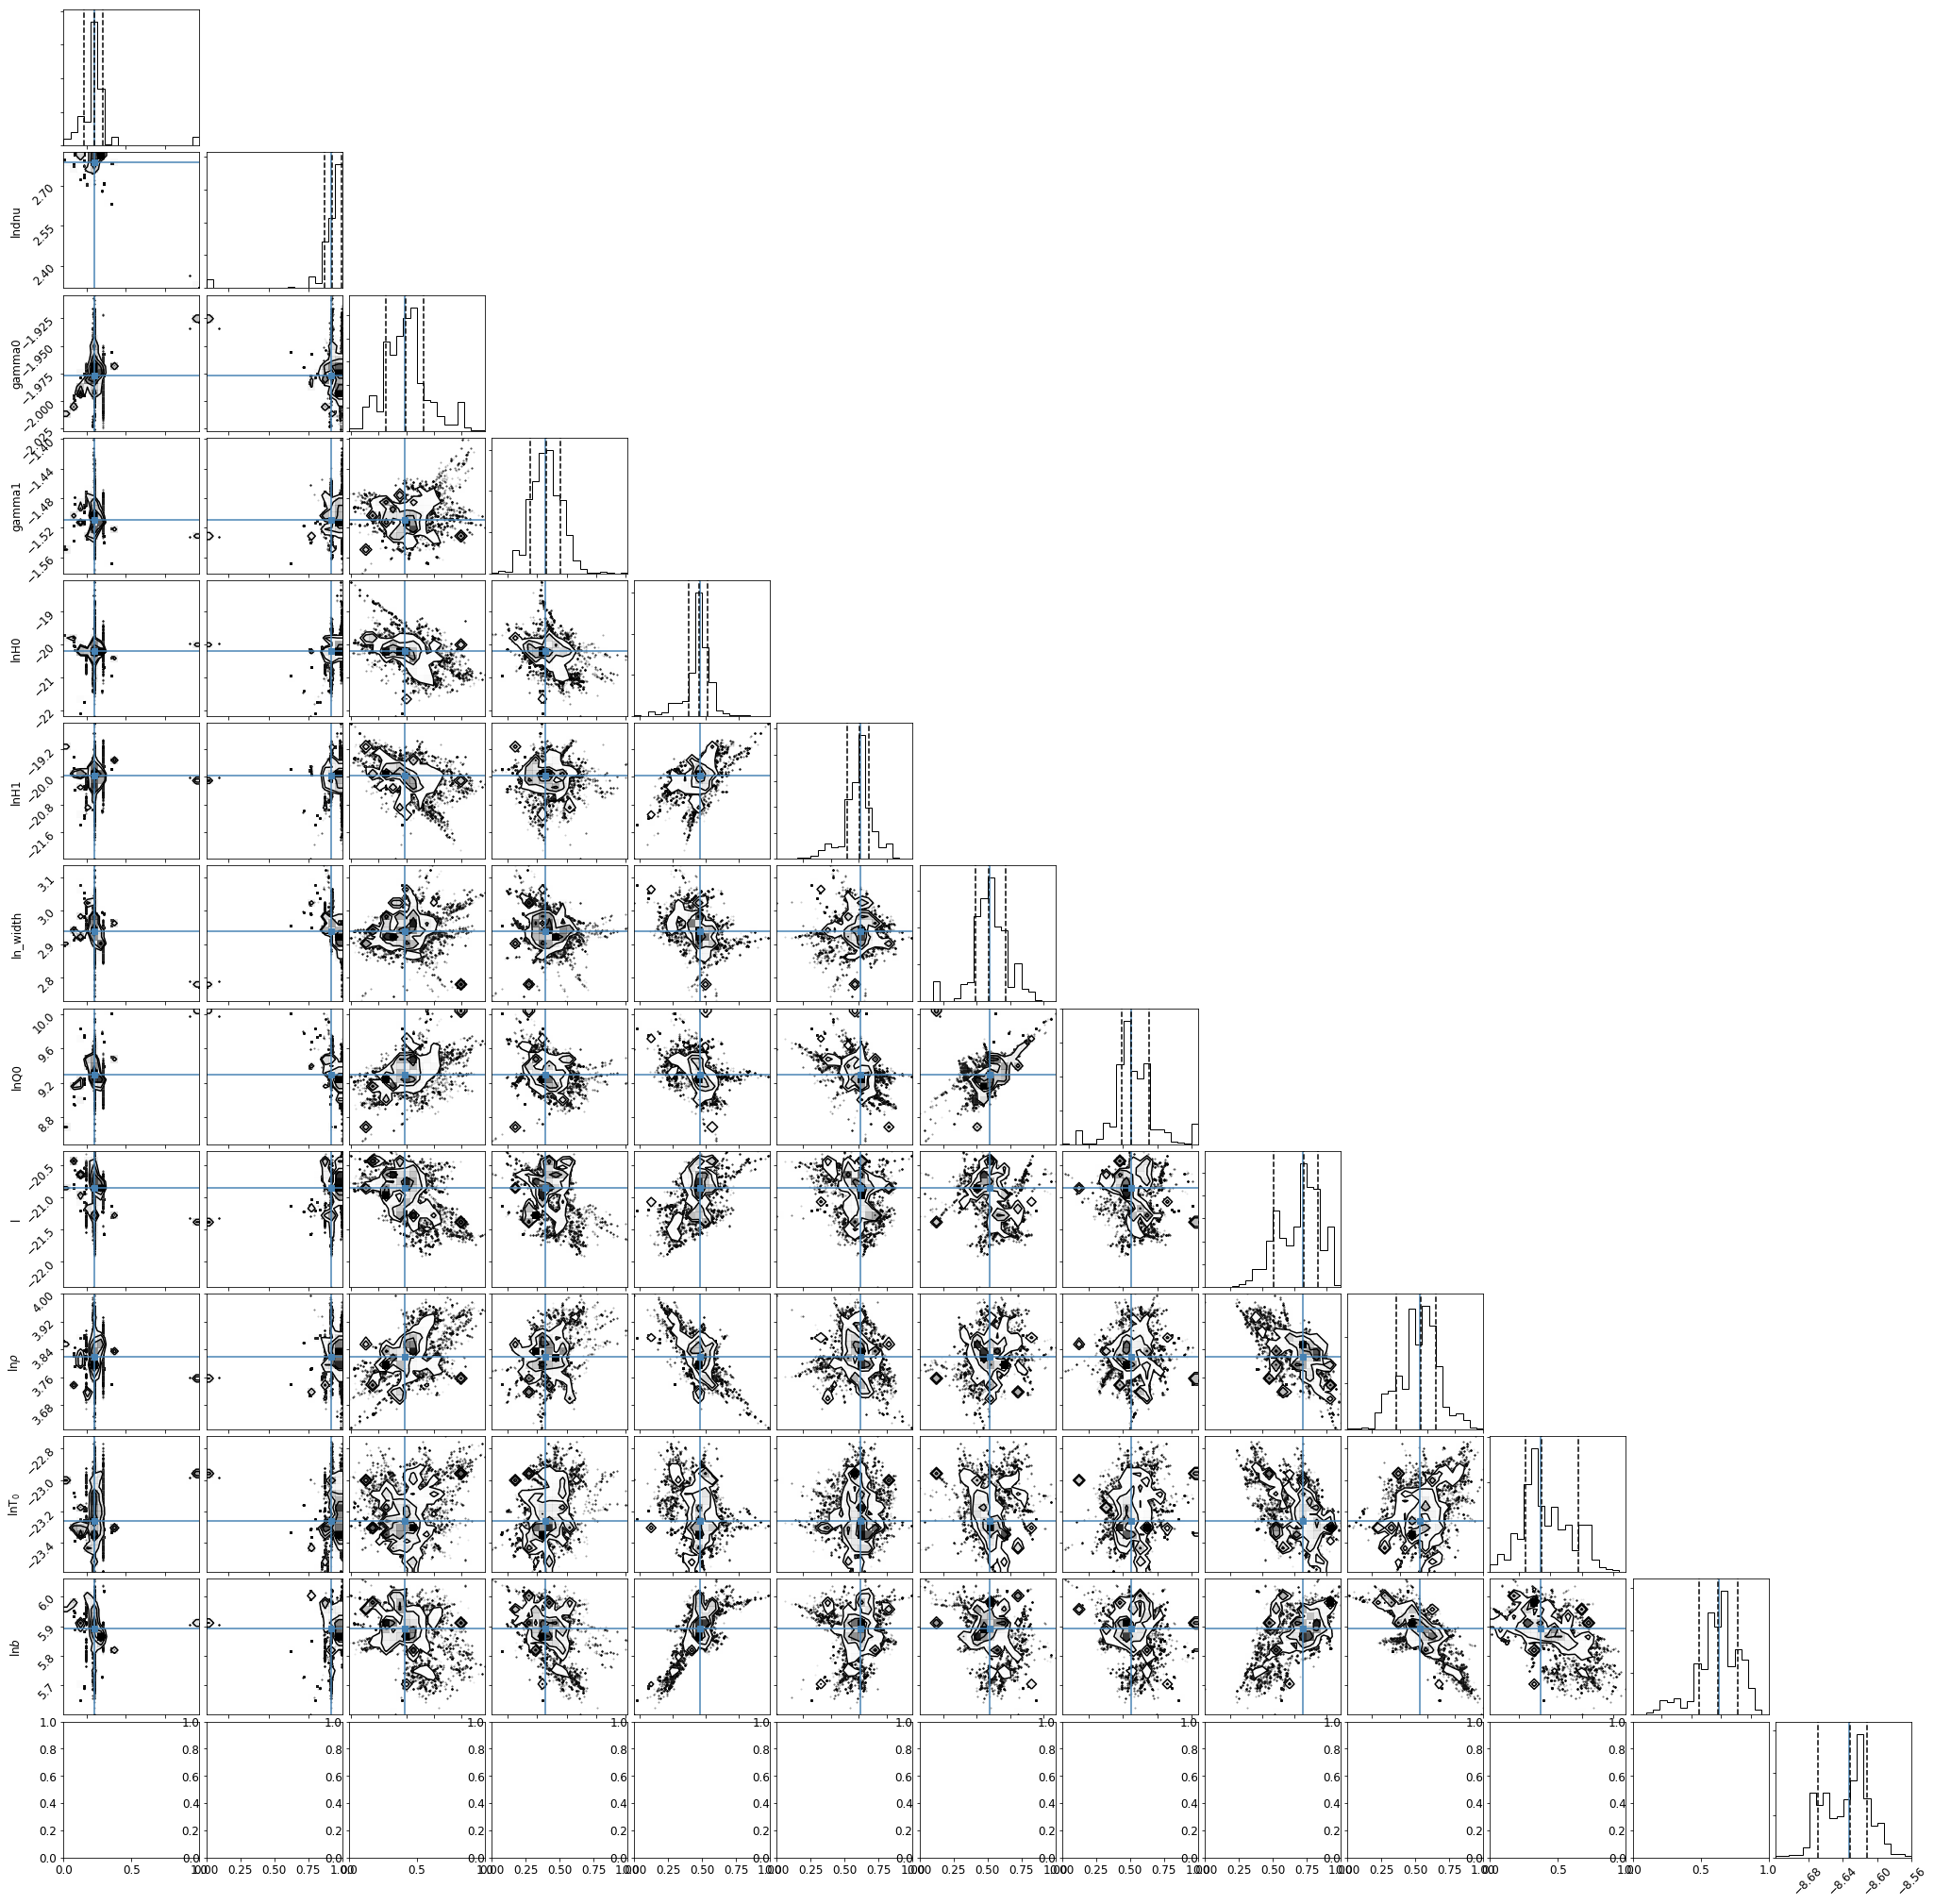

In [419]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

plt.clf()
fig, axes = plt.subplots(len(merged_par), 1, sharex=True, figsize=(8, 9))
axes[0].plot((sampler.chain[:, :, 0].T), color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(np.median(sampler.chain[:, :, 0].T), color="#888888", lw=2)
axes[0].set_ylabel(r"ln_numax")
    
axes[1].plot((sampler.chain[:, :, 1].T), color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(np.median(sampler.chain[:, :, 1].T), color="#888888", lw=2)
axes[1].set_ylabel(r"ln_dnu")

axes[2].plot((sampler.chain[:, :, 2].T), color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(np.median(sampler.chain[:, :, 2].T), color="#888888", lw=2)
axes[2].set_ylabel(r"gamma0")
    
axes[3].plot((sampler.chain[:, :, 3].T), color="k", alpha=0.4)
axes[3].yaxis.set_major_locator(MaxNLocator(5))
axes[3].axhline(np.median(sampler.chain[:, :, 3].T), color="#888888", lw=2)
axes[3].set_ylabel(r"gamma1")

axes[4].plot((sampler.chain[:, :, 4].T), color="k", alpha=0.4)
axes[4].yaxis.set_major_locator(MaxNLocator(5))
axes[4].axhline(np.median(sampler.chain[:, :, 4].T), color="#888888", lw=2)
axes[4].set_ylabel(r"logH0")

axes[5].plot((sampler.chain[:, :, 5].T), color="k", alpha=0.4)
axes[5].yaxis.set_major_locator(MaxNLocator(5))
axes[5].axhline(np.median(sampler.chain[:, :, 5].T), color="#888888", lw=2)
axes[5].set_ylabel(r"logH1")

axes[6].plot((sampler.chain[:, :, 6].T), color="k", alpha=0.4)
axes[6].yaxis.set_major_locator(MaxNLocator(5))
axes[6].axhline(np.median(sampler.chain[:, :, 6].T), color="#888888", lw=2)
axes[6].set_ylabel(r"log_sigma")

axes[7].plot((sampler.chain[:, :, 7].T), color="k", alpha=0.4)
axes[7].yaxis.set_major_locator(MaxNLocator(5))
axes[7].axhline(np.median(sampler.chain[:, :, 7].T), color="#888888", lw=2)
axes[7].set_ylabel(r"log_Q0")

axes[8].plot((sampler.chain[:, :, 8].T), color="k", alpha=0.4)
axes[8].yaxis.set_major_locator(MaxNLocator(5))
axes[8].axhline(np.median(sampler.chain[:, :, 8].T), color="#888888", lw=2)
axes[8].set_ylabel(r"log_S0,0")

axes[9].plot((sampler.chain[:, :, 9].T), color="k", alpha=0.4)
axes[9].yaxis.set_major_locator(MaxNLocator(5))
axes[9].axhline(np.median(sampler.chain[:, :, 9].T), color="#888888", lw=2)
axes[9].set_ylabel(r"log_omega0,0")

axes[10].plot((sampler.chain[:, :, 10].T), color="k", alpha=0.4)
axes[10].yaxis.set_major_locator(MaxNLocator(5))
axes[10].axhline(np.median(sampler.chain[:, :, 10].T), color="#888888", lw=2)
axes[10].set_ylabel(r"logS01")

axes[11].plot((sampler.chain[:, :, 11].T), color="k", alpha=0.4)
axes[11].yaxis.set_major_locator(MaxNLocator(5))
axes[11].axhline(np.median(sampler.chain[:, :, 11].T), color="#888888", lw=2)
axes[11].set_ylabel(r"logomega0,1")

axes[12].plot((sampler.chain[:, :, 12].T), color="k", alpha=0.4)
axes[12].yaxis.set_major_locator(MaxNLocator(5))
axes[12].axhline(np.median(sampler.chain[:, :, 12].T), color="#888888", lw=2)
axes[12].set_ylabel(r"log_whitenoise")


import corner
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


majorFormatter = FormatStrFormatter('%.2f')
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(majorFormatter)

plt.clf()
plt.rcParams["font.size"] = 12
#plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
#plt.rcParams["text.usetex"] = True
#plt. rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
#plt.rcParams['font.size']=18  
fig = corner.corner(samples, labels=[r"lnnumax", r"lndnu", r"gamma0", r"gamma1", r"lnH0", r"lnH1", r"ln_width",\
                                     r"lnQ0", r"l", r"ln$\rho$", r"lnT$_0$", r"ln$b$"], quantiles=[0.16, 0.5, 0.84],
                      truths=[np.median(sampler.chain[:, :, 0].T), np.median(sampler.chain[:, :, 1].T), np.median(sampler.chain[:, :, 2].T), \
                              np.median(sampler.chain[:, :, 3].T), np.median(sampler.chain[:, :, 4].T), np.median(sampler.chain[:, :, 5].T), \
                              np.median(sampler.chain[:, :, 6].T), np.median(sampler.chain[:, :, 7].T), np.median(sampler.chain[:, :, 8].T), \
                              np.median(sampler.chain[:, :, 9].T), np.median(sampler.chain[:, :, 10].T), np.median(sampler.chain[:, :, 11].T), np.median(sampler.chain[:, :, 12].T)])
    
fig.tight_layout()
